In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
%matplotlib inline
plt.style.use('default')

df=pd.read_csv('/datc/opschaler/combined_gas_smart_weather_dfs/processed/P01S01W8655_hour.csv',header=0,delimiter='\t', parse_dates=['datetime'])
df=df.set_index(['datetime'])
df['gasPower']=df['gasPower']*10
dwelling_id = 'P01S01W8655'

In [2]:
sample_rate = '1D'
def resample_df(df, sample_rate, combine_all_dwellings=False):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df.
    Input df may also be multiple dwelling dfs combined.
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    
    Combine all dwellings: resamples the df and ignores the fact that there are unique dwellings.
    
    TODO: add std to ePower, gasPower when combine_all_dwellings=False
    """
    def resample_dwelling(df, sample_rate, dwelling_id):
        df = df.resample(sample_rate).mean() # resample to rest by mean
        df['dwelling'] = dwelling_id
        return df
        
                      
    resampled_dwellings = []
    
    if combine_all_dwellings: # Ignore dwelling_ids
        df = df.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Drop columns because they are meaningless when ignoring dwelling ids
        resampled_df = resample_dwelling(df, sample_rate, 'All dwellings')
        resampled_dwellings.append(resampled_df)
    else:
        dwellings = df['dwelling'].unique() # Get dwelling ids
        for dwelling_id in tqdm(dwellings):
            dwelling_df = df[df['dwelling'] == dwelling_id] # Get the data from only that dwelling_id
            resampled_dwelling = resample_dwelling(dwelling_df, sample_rate, dwelling_id)
            resampled_dwellings.append(resampled_dwelling)
    
    resampled_df = pd.concat(resampled_dwellings)
    
    return resampled_df

rdf=resample_df(df,sample_rate)
trdf = rdf[rdf['T'] < 16]

100%|██████████| 1/1 [00:00<00:00, 135.57it/s]


In [3]:
rdf = rdf.reset_index()
rdf=rdf[np.isfinite(rdf['gasPower'])]
trdf=trdf[np.isfinite(trdf['gasPower'])]

In [4]:
rdf

,datetime,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,...,RG,SQ,T,T10,TD,U,VV,WW,gasPower,dwelling
0,2017-04-24,780.317000,0.0,736.981167,0.0,425.912710,0.0,1592.684833,266.836110,142.333333,...,0.320833,0.308364,10.955556,11.359722,6.690278,75.138890,29418.194500,28.125000,2.013716,P01S01W8655
1,2017-04-25,784.964250,0.0,738.217500,0.0,365.682568,0.0,1595.581708,285.680485,47.416667,...,0.080208,4.004910,6.503472,6.373403,1.977500,72.906250,36118.680500,23.550000,1.501211,P01S01W8655
2,2017-04-26,792.001667,0.0,739.756625,0.0,363.442245,0.0,1601.344913,261.319517,39.000000,...,0.102986,4.090413,6.069097,5.823472,2.151667,76.909722,35074.527917,11.470833,3.757324,P01S01W8655
3,2017-04-27,796.967000,0.0,744.674917,0.0,411.699121,0.0,1608.707583,233.521111,17.708333,...,0.023264,2.682295,6.181319,5.922500,2.129722,76.137500,36665.555917,11.267361,2.139994,P01S01W8655
4,2017-04-28,800.575875,0.0,751.724250,0.0,511.259890,0.0,1614.828083,266.770347,58.366667,...,0.156111,2.737647,7.958750,7.910486,4.364167,78.612500,33648.791625,18.394445,2.516632,P01S01W8655
5,2017-04-29,807.578000,0.0,755.794250,0.0,354.837559,0.0,1620.309522,160.518265,0.000000,...,0.000000,2.944781,7.953264,6.801181,3.223750,73.968750,33187.361167,1.988194,2.425925,P01S01W8655
6,2017-04-30,807.578000,0.0,764.424875,0.0,322.601950,0.0,1625.551167,102.855001,0.000000,...,0.000000,4.255089,12.148820,10.806875,2.246667,52.566667,39318.750083,2.104167,1.994578,P01S01W8655
7,2017-05-01,808.759625,0.0,769.407000,0.0,183.611337,0.0,1627.727542,148.579723,24.750000,...,0.002083,0.164950,12.198125,11.546944,5.892917,65.642361,44689.027667,11.243056,0.654195,P01S01W8655
8,2017-05-02,811.883750,0.0,770.845917,0.0,219.068970,0.0,1629.287458,163.312432,124.000000,...,0.371528,0.188495,10.158750,9.242361,8.072778,86.668056,17492.500083,22.138889,0.884552,P01S01W8655
9,2017-05-03,816.484208,0.0,772.514667,0.0,312.013169,0.0,1631.765375,59.688473,170.500000,...,0.147639,0.837973,10.389931,10.173611,7.958194,84.961111,13207.902729,26.062500,1.126709,P01S01W8655


In [5]:
def append_temperature(df):
    for index in range(len(df)):
        if index==0:
            df['TDB'].iloc[index]=0
        
        else:
            df['TDB'].iloc[index]=df['T'].iloc[index-1]
            
    return df    

In [6]:
rdf['TDB'] = 0
rdf=append_temperature(rdf)
rdf.head()

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,datetime,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,...,SQ,T,T10,TD,U,VV,WW,gasPower,dwelling,TDB
0,2017-04-24,780.317000,0.0,736.981167,0.0,425.912710,0.0,1592.684833,266.836110,142.333333,...,0.308364,10.955556,11.359722,6.690278,75.138890,29418.194500,28.125000,2.013716,P01S01W8655,0.000000
1,2017-04-25,784.964250,0.0,738.217500,0.0,365.682568,0.0,1595.581708,285.680485,47.416667,...,4.004910,6.503472,6.373403,1.977500,72.906250,36118.680500,23.550000,1.501211,P01S01W8655,10.955556
2,2017-04-26,792.001667,0.0,739.756625,0.0,363.442245,0.0,1601.344913,261.319517,39.000000,...,4.090413,6.069097,5.823472,2.151667,76.909722,35074.527917,11.470833,3.757324,P01S01W8655,6.503472
3,2017-04-27,796.967000,0.0,744.674917,0.0,411.699121,0.0,1608.707583,233.521111,17.708333,...,2.682295,6.181319,5.922500,2.129722,76.137500,36665.555917,11.267361,2.139994,P01S01W8655,6.069097
4,2017-04-28,800.575875,0.0,751.724250,0.0,511.259890,0.0,1614.828083,266.770347,58.366667,...,2.737647,7.958750,7.910486,4.364167,78.612500,33648.791625,18.394445,2.516632,P01S01W8655,6.181319


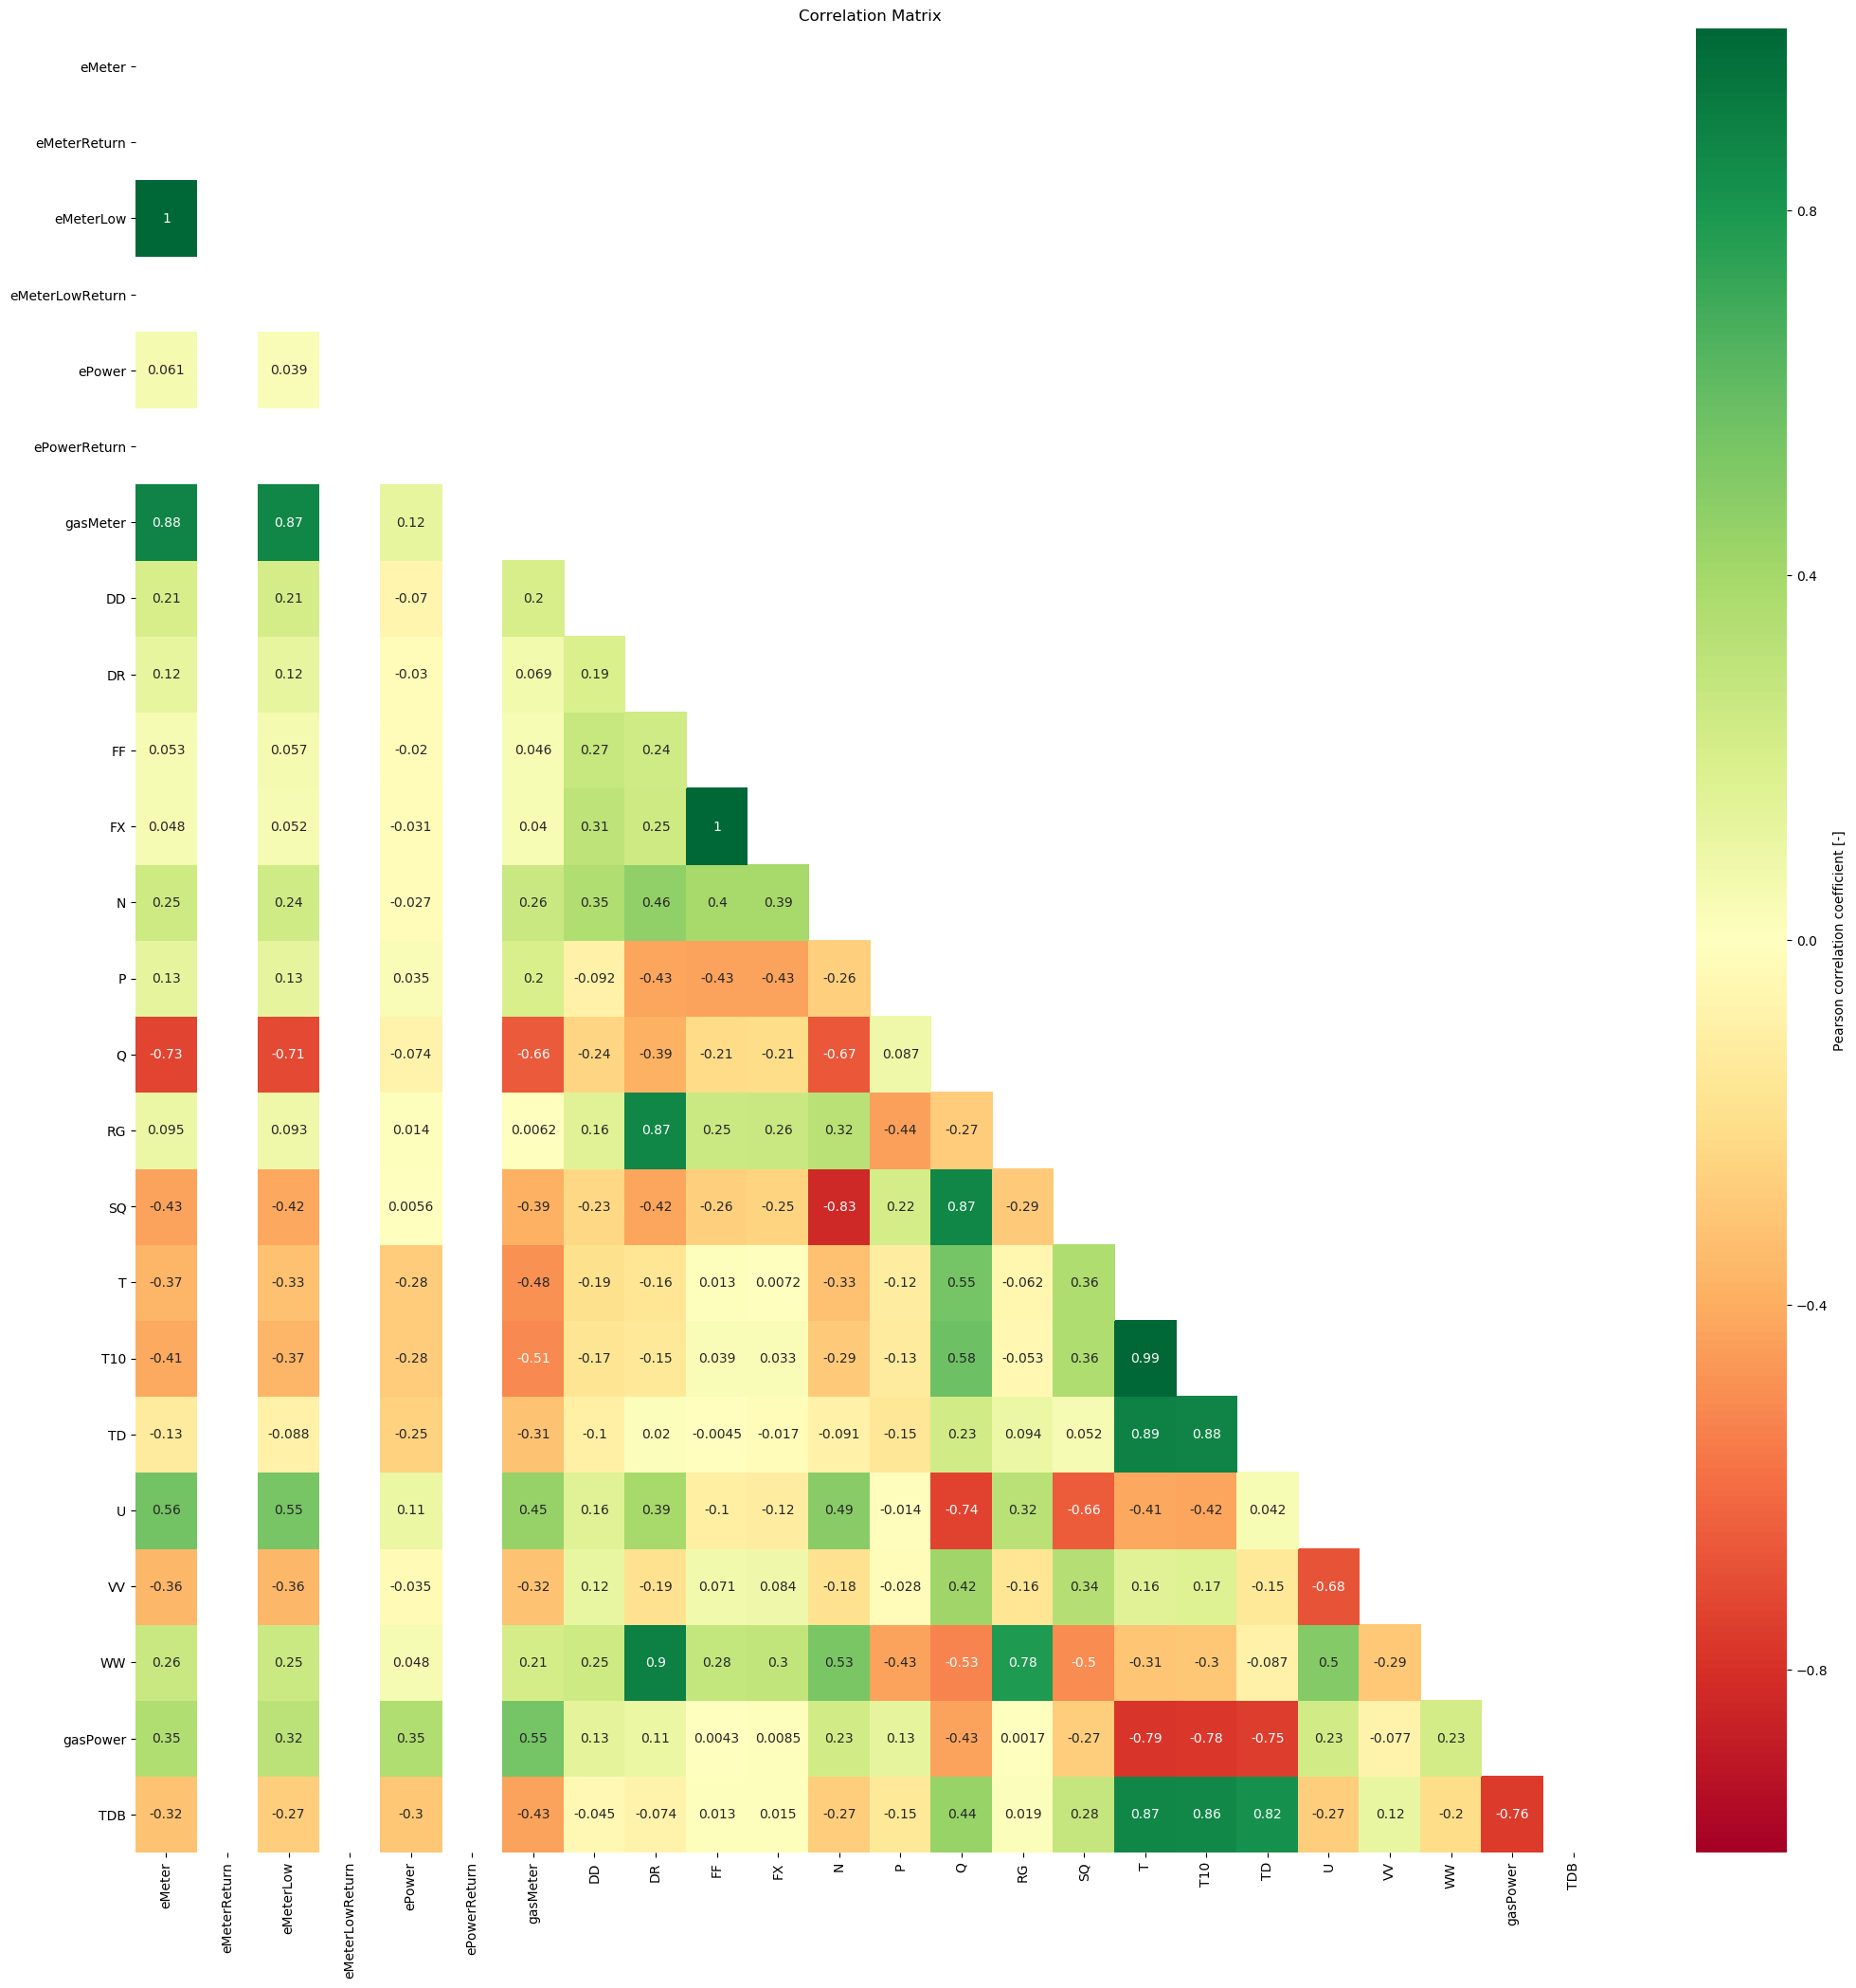

In [7]:
corr = rdf.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(25,25))

sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=True, ax=ax,
            cbar_kws={'label':'Pearson correlation coefficient [-]'})

plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
#plt.savefig('sample.png', dpi=500)
plt.show()

In [8]:
rdf=rdf.drop(0)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X = rdf[['T']]
y = rdf[['gasPower']]

X = np.array(X).reshape(-1,1) # Reshape because sklearn wants you to
y = np.array(y).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
len(X_train)

144

In [11]:
model.score(X_test, y_test)

0.5709175941245457

In [12]:
print(model.get_params(deep=True))

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}


In [16]:
Y_prediction=model.predict(X_test)

plt.plot(X_train.indices,y_train,'.',label='TRAINED DATA')
plt.plot(X_test.indices,Y_prediction,'-',label='PREDICTED DATA')     
plt.plot(X_test.indices,y_test,'.',label='TEST DATA')

plt.grid(True)
plt.title('1 WEEK PREDICTION \n T,WW \nMSE: '+ str(mean_squared_error(y_test,Y_prediction)))
plt.xlabel( 'Datetime' )
plt.ylabel('gasPower [m$^3$ per hour]')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'indices'